In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

- MNIST DATASet에 SELU 활성화 함수를 사용해 Stack AE를 만든다.
- 왜 SeLU를 써야 할까?
- Layer 구성
    - AE 모델을 Encoder 와 Decoder 두개의 서브 모델로 나눈다. 
    - 인코더는 28 x 28 픽셀의 흑백 이미지를 받는다. 
    - 각 입력 이미지에 대해 인코더는 크기가 30인 벡터를 출력한다.
    
    - 디코더는 인코더가 출력한 값을 받는다. 
    - 100개의 노드를 가진 Layer를 지나 784개의 유닛을 갖는 Layer를 통과시키고28X28 행렬로 변경해준다. 
    - Stack AE를 컴파일 할때 MSE 대신 binary_crossentropy Error를 사용한다. 이는 각 필셀이 검정일 확률을 나타내는 것이다. 

# SeRu


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
])

# https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])


stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3599 - rounded_accuracy: 0.8611 - val_loss: 0.3254 - val_rounded_accuracy: 0.8959
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3129 - rounded_accuracy: 0.9077 - val_loss: 0.3135 - val_rounded_accuracy: 0.9113
Epoch 3/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3041 - rounded_accuracy: 0.9157 - val_loss: 0.3058 - val_rounded_accuracy: 0.9098
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2985 - rounded_accuracy: 0.9209 - val_loss: 0.2967 - val_rounded_accuracy: 0.9251
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2946 - rounded_accuracy: 0.9246 - val_loss: 0.2954 - val_rounded_accuracy: 0.9226
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2917 - rounded_accuracy: 0.9274 - val_loss: 0.2943 - val_rounded_accuracy: 0.9276
Epoch 7/20
1719/1719 [==================

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

1/1 [==============================] - 0s 79ms/step


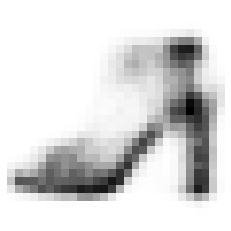

In [ ]:
reconstructions = stacked_ae.predict(X_valid[4:5])
plot_image(reconstructions[0])

In [ ]:
X_valid[1].shape

(28, 28)

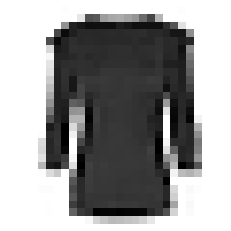

In [ ]:
plot_image(X_valid[0])

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 16ms/step


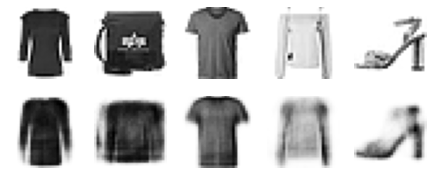

In [ ]:
show_reconstructions(stacked_ae)

# Data Set의 시각화
- Stack AE 를 통해 DataSet의 차원을 축소 할수 있다. 
    - 다른 차원 축소 알고리즘만큼의 좋은 결과를 주지는 못하지만, 샘플과 특성이 많은 대용량 데이터셋을 다룰수 있다는 장점이 있다.
    - Stack Encoder의 Encoder 모델을 사용해 차원을 30 으로 줄인다.
    - 30 차원을 t-SNE 알고리즘을 이용해 2차원으로 줄인다.
    - AutoEncoder 사용후 t-SNE 알고리즘 사용

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


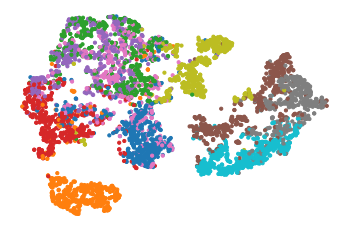

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

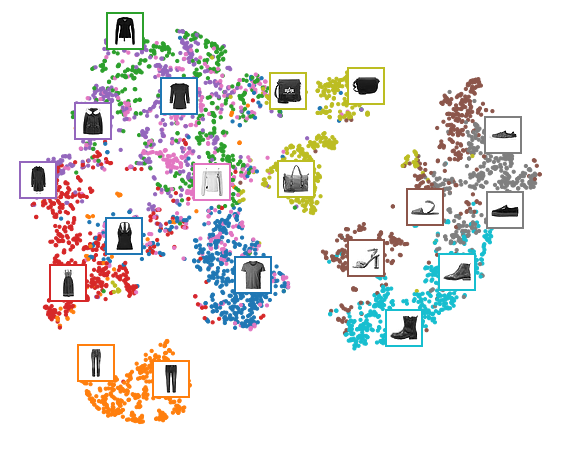

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=20,
                           validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9238
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/20
1719/1719 [==================

1/1 [==============================] - 0s 51ms/step


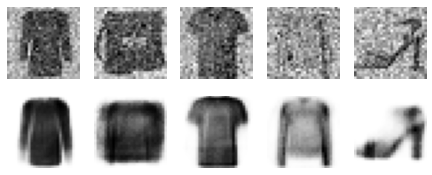

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

1/1 [==============================] - 0s 49ms/step


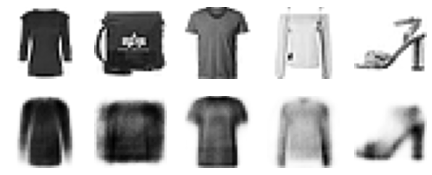

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, X_valid)
plt.show()

# Convolution Layer 를 이용한 AE

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5
1719/1719 [==============================] - 16s 5ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2849 - val_rounded_accuracy: 0.9287
Epoch 2/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9454
Epoch 3/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2708 - rounded_accuracy: 0.9461 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2682 - rounded_accuracy: 0.9489 - val_loss: 0.2685 - val_rounded_accuracy: 0.9493
Epoch 5/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2672 - val_rounded_accuracy: 0.9508


In [ ]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

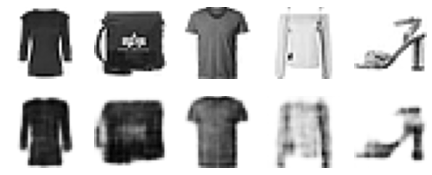

In [ ]:
show_reconstructions(conv_ae)
plt.show()

# Stacked denoising Autoencoder
## Using Gaussian noise

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9237
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 59ms/step


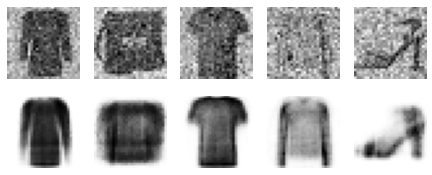

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [ ]:
# drop out 사용

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 64ms/step


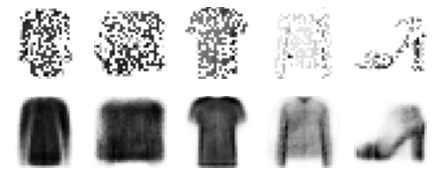

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

# VAE

In [ ]:
#샘플링 Class 생성
# Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) epsilon추출 
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = K.random_normal(tf.shape(log_var))
        return epsilon * K.exp(log_var / 2) + mean


In [ ]:
# Keras는 model-level의 라이브러리 
# 딥러닝 모델을 만들 때 레이어를 제공 한다.
# Keras는 텐서 곱셈, 합성곱 등의 저수준의 연산을 제공하지 않기 때문에 
# 새로운 함수를 만들기 위해서는 K 가 갖고있는 함수를 사용한다. 
import tensorflow.keras.backend as K

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

In [ ]:
# 평균(mean)과 표준편차(sigma)층을 정의. 
# 이때 sigma 대신 log variance를 사용한다
# 이는 신경망의 출력은 음수를 가질 수 있지만 sigma는 항상 양수여야 하기 때문이다. 
    
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)


# Sampling 객체를 이용해  mean과 var 를 계산
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])


In [ ]:

# Decoder 생성과정
# 디코더의 입력층 생성 (Decoder의 입력은 latent)

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
# Model 생성
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
# K 가 갖고 있는 sum, exp,  square 함수를 이용해 
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 6s 6ms/step - loss: 0.3892 - rounded_accuracy: 0.8612 - val_loss: 0.3612 - val_rounded_accuracy: 0.8896
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3425 - rounded_accuracy: 0.8980 - val_loss: 0.3441 - val_rounded_accuracy: 0.8979
Epoch 3/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3327 - rounded_accuracy: 0.9053 - val_loss: 0.3406 - val_rounded_accuracy: 0.9021
Epoch 4/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3277 - rounded_accuracy: 0.9091 - val_loss: 0.3282 - val_rounded_accuracy: 0.9119
Epoch 5/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3246 - rounded_accuracy: 0.9118 - val_loss: 0.3266 - val_rounded_accuracy: 0.9138
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3223 - rounded_accuracy: 0.9138 - val_loss: 0.3290 - val_rounded_accuracy: 0.9040
Epoch 7/25
430/430 [==============================] 

1/1 [==============================] - 0s 15ms/step


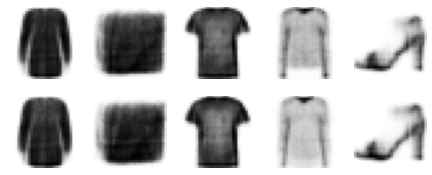

In [ ]:
show_reconstructions(variational_ae, variational_ae(X_valid, training=True))

In [ ]:
variational_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_4 (Dense)             (None, 100)               1100      
                                                                 
 dense_5 (Dense)             (None, 150)               15150     
                                                                 
 dense_6 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 134,634
Trainable params: 134,634
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 15ms/step


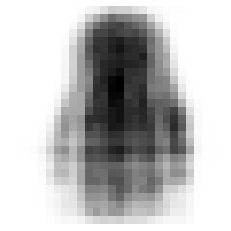

In [ ]:
plot_image(variational_decoder.predict(np.random.rand(1,10)).reshape(28,28))

In [ ]:
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               3100      
                                                                 
 dense_10 (Dense)            (None, 784)               79184     
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 14ms/step


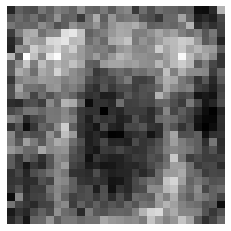

In [ ]:
plot_image(denoising_decoder.predict((np.random.rand(1,30))).reshape(28,28))